In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import regex as re
from collections import defaultdict

class BPETokenizer:
    def __init__(self, vocab_size=3000):
        self.vocab_size = vocab_size
        self.merges = {}
        self.vocab = {}
        self.history = []  # Возвращаем атрибут истории
        self.pattern = re.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")

    def get_stats(self, ids):
        counts = defaultdict(int)
        for pair in zip(ids, ids[1:]):
            counts[pair] += 1
        return counts

    def merge_ids(self, ids, pair, idx):
        new_ids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                new_ids.append(idx)
                i += 2
            else:
                new_ids.append(ids[i])
                i += 1
        return new_ids

    def train(self, text, track_compression=False):
        text_chunks = re.findall(self.pattern, text)
        ids = [list(ch.encode("utf-8")) for ch in text_chunks]

        num_merges = self.vocab_size - 256
        initial_bytes = len(text.encode("utf-8"))

        for i in range(num_merges):
            stats = defaultdict(int)
            for chunk in ids:
                for pair in zip(chunk, chunk[1:]):
                    stats[pair] += 1
            
            if not stats:
                break

            pair = max(stats, key=stats.get)
            idx = 256 + i
            
            ids = [self.merge_ids(chunk, pair, idx) for chunk in ids]
            self.merges[pair] = idx

            # Логика трекинга сжатия
            if track_compression and i % 50 == 0:
                current_tokens = sum(len(chunk) for chunk in ids)
                if current_tokens > 0:
                    self.history.append((256 + i + 1, initial_bytes / current_tokens))

        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]
            
    def encode(self, text):
        text_chunks = re.findall(self.pattern, text)
        ids = []
        for chunk in text_chunks:
            chunk_ids = list(chunk.encode("utf-8"))
            while len(chunk_ids) >= 2:
                stats = self.get_stats(chunk_ids)
                pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
                if pair not in self.merges:
                    break
                idx = self.merges[pair]
                chunk_ids = self.merge_ids(chunk_ids, pair, idx)
            ids.extend(chunk_ids)
        return ids

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids if idx in self.vocab)
        return tokens.decode("utf-8", errors="replace")

подгрузим данные (берем войну и мир, т.к. я тулячок)

In [63]:
def download_robust(filename, urls):
    headers = {'User-Agent': 'Mozilla/5.0'}
    for url in urls:
        try:
            print(f"Trying to download from: {url}")
            response = requests.get(url, headers=headers, timeout=20)
            if response.status_code == 200 and len(response.content) > 1000:
                with open(filename, 'wb') as f:
                    f.write(response.content)
                print("Success.")
                return True
            else:
                print(f"Failed status: {response.status_code}")
        except Exception as e:
            print(f"Error: {e}")
    return False

train_urls = [
    "https://gist.githubusercontent.com/Semionn/bdcb66640cc070450817686f6c818897/raw"
]

if not download_robust("train_corpus.txt", train_urls):
    raise Exception("Failed to download training corpus.")

with open("train_corpus.txt", "r", encoding="utf-8") as f:
    full_text = f.read()

split_idx = int(len(full_text) * 0.95)
train_text = full_text[:split_idx]
test_text_literature = full_text[split_idx:split_idx+20000]

tech_text = """
def optimize_transformer(model):
    if not model.compiled:
        model.compile(optimizer='adam', loss='mse')
    return model.evaluate()
# JSON configuration for BPE
config = {
    "vocab_size": 5000,
    "special_tokens": ["<|endoftext|>"]
}
"""

tokenizer = BPETokenizer(vocab_size=3000)
tokenizer.train(train_text[:500000], track_compression=True)

Trying to download from: https://gist.githubusercontent.com/Semionn/bdcb66640cc070450817686f6c818897/raw
Success.


метрики

In [64]:
def calculate_metrics(tokenizer, text, domain_name):
    tokens = tokenizer.encode(text)
    num_tokens = len(tokens)
    num_bytes = len(text.encode("utf-8"))
    
    words = text.split()
    num_words = len(words)
    
    word_counts = Counter(words)
    top_10_percent_count = int(len(word_counts) * 0.1) or 1
    top_words = set(word for word, _ in word_counts.most_common(top_10_percent_count))
    
    top_words_tokens = 0
    top_words_count = 0
    
    for word in words:
        if word in top_words:
            top_words_tokens += len(tokenizer.encode(word))
            top_words_count += 1
            
    avg_tokens_per_word = num_tokens / num_words if num_words > 0 else 0
    avg_tokens_top_10 = top_words_tokens / top_words_count if top_words_count > 0 else 0
    compression_ratio = num_bytes / num_tokens if num_tokens > 0 else 0

    return {
        "Domain": domain_name,
        "Compression Ratio": compression_ratio,
        "Avg Tokens/Word": avg_tokens_per_word,
        "Avg Tokens/Word (Top 10%)": avg_tokens_top_10
    }

metrics_lit = calculate_metrics(tokenizer, test_text_literature, "Literature (Native)")
metrics_tech = calculate_metrics(tokenizer, tech_text, "Technical (Out of Domain)")

print(f"{metrics_lit['Domain']}:")
print(f"  Compression Ratio: {metrics_lit['Compression Ratio']:.2f}")
print(f"  Avg Tokens/Word: {metrics_lit['Avg Tokens/Word']:.2f}")
print(f"  Avg Tokens/Word (Top 10%): {metrics_lit['Avg Tokens/Word (Top 10%)']:.2f}")

print(f"\n{metrics_tech['Domain']}:")
print(f"  Compression Ratio: {metrics_tech['Compression Ratio']:.2f}")
print(f"  Avg Tokens/Word: {metrics_tech['Avg Tokens/Word']:.2f}")
print(f"  Avg Tokens/Word (Top 10%): {metrics_tech['Avg Tokens/Word (Top 10%)']:.2f}")

Literature (Native):
  Compression Ratio: 5.64
  Avg Tokens/Word: 1.84
  Avg Tokens/Word (Top 10%): 1.71

Technical (Out of Domain):
  Compression Ratio: 1.27
  Avg Tokens/Word: 8.82
  Avg Tokens/Word (Top 10%): 12.00


Native Domain 

Compression Ratio (5.64) - показатель высокий получается . Это объясняется тем, что в кодировке UTF-8 кириллические символы занимают 2 байта. Токенизатор научился объединять длинные последовательности (корни, окончания, целые слова) в один токен. Например, слово из 5 букв (10 байт) может стать 1 токеном, давая коэффициент сжатия 10.
Avg Tokens/Word (1.84) - низкое значение показывает, что большинство слов разбивается всего на 1-2 токена, что говорит о качественном словаре для этого домена.

Out of Domain 

Compression Ratio (1.27) - ну тут низкий показатель, близкий к 1. Это означает, что текст практически не сжимается. Английские символы занимают 1 байт, и поскольку токенизатор не знает английских слов, он разбивает их на отдельные символы-токены (1 байт ≈ 1 токен).
Avg Tokens/Word (8.82) - очень высокое значение. Английские слова и команды кода (например, optimizer) не найдены в словаре и разбиваются по буквам, генерируя много токенов на одно слово

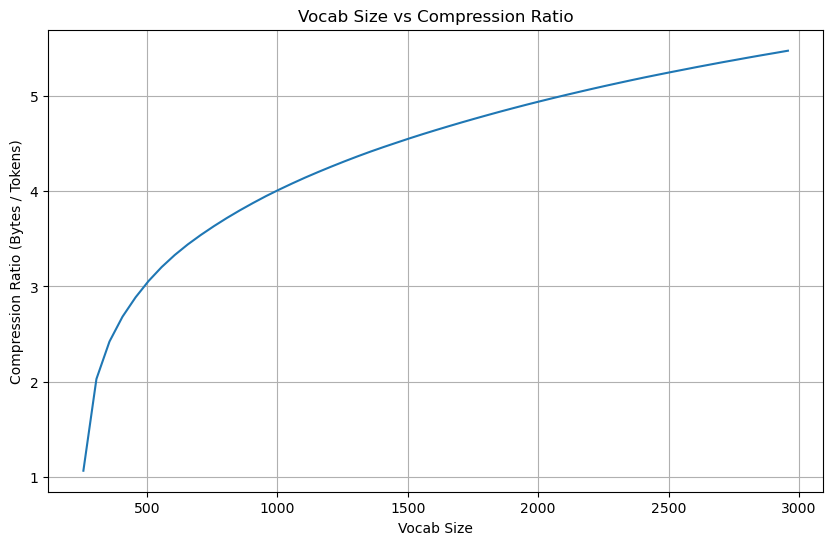

In [65]:
x_vals = [x[0] for x in tokenizer.history]
y_vals = [x[1] for x in tokenizer.history]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals)
plt.title("Vocab Size vs Compression Ratio")
plt.xlabel("Vocab Size")
plt.ylabel("Compression Ratio (Bytes / Tokens)")
plt.grid(True)
plt.show()

In [66]:
import os
from collections import Counter

pushkin_token_counts = Counter()

for i in range(1, 840):
    file_path = f"texts/A{i}.txt"
    if os.path.exists(file_path):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
            tokens = tokenizer.encode(text)
            pushkin_token_counts.update(tokens)
        except Exception:
            continue

total_possible_tokens = 256 + len(tokenizer.merges)
used_tokens_count = len(pushkin_token_counts)
unused_tokens_count = total_possible_tokens - used_tokens_count
percent_unused = (unused_tokens_count / total_possible_tokens) * 100

print(f"Total vocab size: {total_possible_tokens}")
print(f"Used tokens in Pushkin corpus: {used_tokens_count}")
print(f"Unused tokens: {unused_tokens_count}")
print(f"Percentage of unused tokens: {percent_unused:.2f}%")

Total vocab size: 3000
Used tokens in Pushkin corpus: 2529
Unused tokens: 471
Percentage of unused tokens: 15.70%


неплохо покрывает, в 15 процентов укладывается специфичная для толстого лексика (вставки на французском и т.д.)

дальше задание 2

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

class ImprovedRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        out, hidden = self.lstm(embeds, hidden)
        out = self.fc(out)
        return out, hidden

In [79]:
def get_batch(data, seq_len, batch_size):
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([torch.tensor(data[i:i+seq_len], dtype=torch.long) for i in ix])
    y = torch.stack([torch.tensor(data[i+1:i+seq_len+1], dtype=torch.long) for i in ix])
    return x, y

tokens = tokenizer.encode(train_text)
vocab_size = len(tokenizer.vocab) 
embed_dim = 128
hidden_dim = 256
num_layers = 2
seq_len = 64
batch_size = 64
learning_rate = 0.002
epochs = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedRNN(vocab_size, embed_dim, hidden_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [80]:
model.train()
for i in range(epochs):
    x_batch, y_batch = get_batch(tokens, seq_len, batch_size)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    optimizer.zero_grad()
    output, _ = model(x_batch, None) 
    loss = criterion(output.reshape(-1, vocab_size), y_batch.reshape(-1))
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if i % 500 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")

Step 0, Loss: 8.0115
Step 500, Loss: 5.0538


In [82]:
def generate_text(model, start_str, length=100, temperature=0.8):
    model.eval()
    context_ids = tokenizer.encode(start_str)
    context = torch.tensor(context_ids, dtype=torch.long).unsqueeze(0).to(device)
    generated = list(context_ids)
    hidden = None
    
    with torch.no_grad():
        output, hidden = model(context, hidden)
        logits = output[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        
        generated.append(next_token.item())
        current_input = next_token
        
        for _ in range(length - 1):
            output, hidden = model(current_input, hidden)
            logits = output[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            generated.append(next_token.item())
            current_input = next_token
            
    return tokenizer.decode(generated)

In [83]:
print(generate_text(model, "Князь Андрей", length=100))
print("-" * 30)
print(generate_text(model, "Пьер", length=100))

Князь Андрей были однуфочность и, неуплялся, но я не было, – Долохов, что он испытляться.
– Князь Андрей, кроме хуже, мерен, – ilmise,
Но в этомсуна.
Долохов князя Андрея, и усталости и привыклись, и он была всё, что она позволило не хылался, во фех он, задумаясь на него. Он говорил уже и в эту минуту, надоч
------------------------------
Пьер, ожидая ему тудить моем (есты, броверной сделать…]
– Et vous de par l'apez de totre depisz, [Толрафиня не не пужил.
– Нудрость, и дело в это время, что он есть так же бедно спросил, что первое крась мози и не нужно? Ростов Пьер?
– Я только что я очень сделай, что вы вступавшие.
